In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

import pickle
import os

import matplotlib.ticker as mtick

In [2]:
# Specify the location of the weights of the pre-trained baseline model
BASELINE_MODEL = "weights_rafdb/model_weights_1626211720.h5"

# Load baseline model's history

In [3]:
file = open("weights_rafdb/model_history_1626211720", "rb")
baseline_history = pickle.load(file)

### Plot training and validation accuracy 

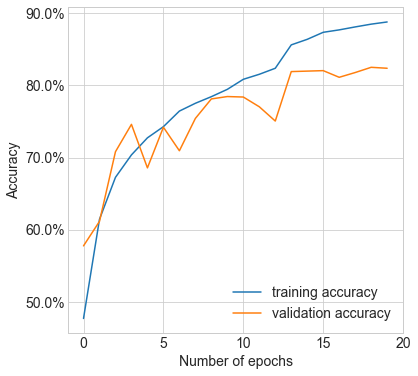

In [4]:
fg = plt.figure(1, (6,6))
ax = fg.add_subplot(1,1,1)

plt.tick_params(labelsize=14)

plt.plot(baseline_history["accuracy"], label="training accuracy")
plt.plot(baseline_history["val_accuracy"], label="validation accuracy")
plt.legend(loc="lower right", prop={'size': 14})

plt.xlabel("Number of epochs", size=14)
plt.ylabel("Accuracy", size=14)

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)

ax.set_xticks(np.arange(0, 21, step=5))

plt.savefig("figures_rafdb/acc.svg")

### Plotting training and validation loss 

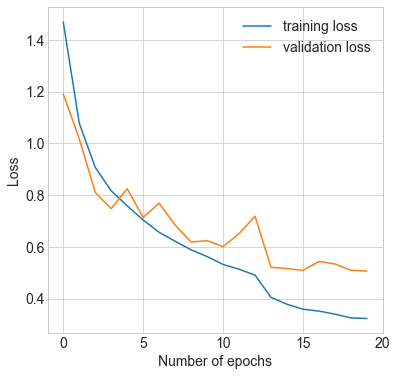

In [5]:
fg = plt.figure(1, (6,6))
ax = fg.add_subplot(1,1,1)

plt.tick_params(labelsize=14)

plt.plot(baseline_history["loss"], label="training loss")
plt.plot(baseline_history["val_loss"], label="validation loss")
plt.legend(loc="upper right", prop={'size': 14})

plt.xlabel("Number of epochs", size=14)
plt.ylabel("Loss", size=14)

ax.set_xticks(np.arange(0, 21, step=5))

plt.savefig("figures_rafdb/loss.svg")

### Report baseline model performance

In [6]:
print("Baseline model performance:")
file = open("logs_rafdb/model_metrics_1626211720", "rb")
baseline_metrics = pickle.load(file)
print("Size:", baseline_metrics["size"])
print("Overall accuracy:", baseline_metrics["acc"])
print("Female accuracy:", baseline_metrics["f_acc"])
print("Male accuracy:", baseline_metrics["m_acc"])

Baseline model performance:
Size: 29801825
Overall accuracy: 0.8246414602346805
Female accuracy: 0.8333333333333334
Male accuracy: 0.8054443554843875


# Auxiliary Functions

**All features**
```'size',
'acc',
'f_acc',
'm_acc', 
'caucasian_acc'
'afamerican_acc',
'asian_acc',
'age0_acc',
'age1_acc',
'age2_acc',
'age3_acc',
'age4_acc'```

In [7]:
def get_samples(method, parameter=None): 
    logs = !ls logs_rafdb
    if method == "pruning": 
        relevant_logs = list(filter(lambda x: ("pruned_model_metrics_s" + str(parameter)) in x, logs))
    if method == "pruning_and_quantisation": 
        relevant_logs = list(filter(lambda x: ("pruned_and_quantised_model_metrics_s" + str(parameter)) in x, logs))
    elif method == "clustering":
        relevant_logs = list(filter(lambda x: ("clustered_model_metrics_c" + str(parameter)) in x, logs))
    elif method == "clustering_and_quantisation":
        relevant_logs = list(filter(lambda x: ("clustered_and_quantised_model_metrics_c" + str(parameter)) in x, logs))
    elif method == "quantisation": 
        relevant_logs = list(filter(lambda x: x[0] == "q" and "quantised_model_metrics" in x, logs))
        
    all_metrics = []
    for log in relevant_logs: 
        file = open("logs_rafdb/" + log,'rb')
        all_metrics.append(pickle.load(file))

    samples = {'size': [], 'acc': [], 'f_acc': [], 'm_acc': [], 'caucasian_acc': [], 'afamerican_acc': [], 
              'asian_acc': [], 'age0_acc': [], 'age1_acc': [], 'age2_acc': [], 'age3_acc': [], 'age4_acc': []}
    for metrics in all_metrics: 
        for key in samples: 
            samples[key].append(metrics[key])
                
    return samples

In [8]:
def get_results_for(method, parameter=None): 
    samples = get_samples(method, parameter)

    return {
        "mean": {key: sum(samples[key])/len(samples[key]) for key in samples}, 
        "sd": {key: np.std(samples[key]) for key in samples}
    }

# 1. Quantisation

In [9]:
quant_results = get_results_for("quantisation")

In [10]:
quant_results

{'mean': {'size': 6568174.0,
  'acc': 0.8246414602346805,
  'f_acc': 0.8320987654320988,
  'm_acc': 0.8070456365092074,
  'caucasian_acc': 0.8192258613356018,
  'afamerican_acc': 0.8675213675213675,
  'asian_acc': 0.8302277432712215,
  'age0_acc': 0.8996960486322189,
  'age1_acc': 0.8292181069958847,
  'age2_acc': 0.8050541516245487,
  'age3_acc': 0.8565737051792829,
  'age4_acc': 0.7078651685393258},
 'sd': {'size': 0.0,
  'acc': 0.0,
  'f_acc': 0.0,
  'm_acc': 0.0,
  'caucasian_acc': 0.0,
  'afamerican_acc': 0.0,
  'asian_acc': 0.0,
  'age0_acc': 0.0,
  'age1_acc': 0.0,
  'age2_acc': 0.0,
  'age3_acc': 0.0,
  'age4_acc': 0.0}}

### Size comparison

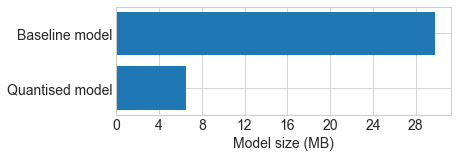

In [11]:
fg = plt.figure(1, (6,2))
ax = fg.add_subplot(1,1,1)

plt.tick_params(labelsize=14)

models = ['Baseline model', 'Quantised model']
y_pos = np.arange(2)
performance = [baseline_metrics["size"], quant_results["mean"]["size"]]
error = [0, quant_results["sd"]["size"]]

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis() 
ax.set_xlabel('Model size (MB)', size=14)

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x // 1000000)
    return s

ax.set_xticks(np.arange(0, 32000000, step=4000000))
yfmt = mtick.FuncFormatter(numfmt)    # create your custom formatter function
ax.xaxis.set_major_formatter(yfmt)

plt.savefig("figures/quantisation_results.svg")

### Accuracy comparison

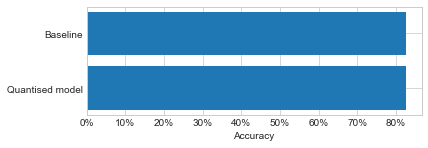

In [12]:
fg = plt.figure(1, (6,2))
ax = fg.add_subplot(1,1,1)

models = ['Baseline', 'Quantised model']
y_pos = np.arange(2)
performance = [baseline_metrics["acc"], quant_results["mean"]["acc"]]
error = [0, quant_results["sd"]["acc"]]

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(models)
ax.invert_yaxis() 
ax.set_xlabel('Accuracy')

yticks = mtick.PercentFormatter(1.0)
ax.xaxis.set_major_formatter(yticks)

plt.show()

### Fairness comparison

In [13]:
print("Before quantisation")
print("Female accuracy:", baseline_metrics["f_acc"])
print("Male accuracy:", baseline_metrics["m_acc"])

print("After quantisation")
print("Female accuracy:", quant_results["mean"]["f_acc"], "sd:", quant_results["sd"]["f_acc"])
print("Male accuracy:", quant_results["mean"]["m_acc"], "sd:", quant_results["sd"]["m_acc"])

Before quantisation
Female accuracy: 0.8333333333333334
Male accuracy: 0.8054443554843875
After quantisation
Female accuracy: 0.8320987654320988 sd: 0.0
Male accuracy: 0.8070456365092074 sd: 0.0


# 2. Pruning

### Size

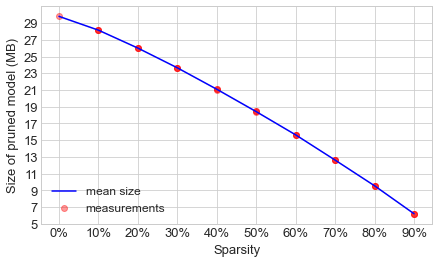

<Figure size 432x288 with 0 Axes>

In [14]:
sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]
size_points = []

size_means = [get_results_for("pruning", n)["mean"]["size"] for n in sparsities]
size_sds = [get_results_for("pruning", n)["sd"]["size"] for n in sparsities]

for n in sparsities:
    size_points += [(n, size) for size in (get_samples("pruning", n)["size"])]
    
sparsities = [0] + sparsities 
size_means = [baseline_metrics["size"]] + size_means
size_sds = [0] + size_sds
size_points.append((0, baseline_metrics["size"]))

size_means = np.array(size_means)
size_sds = np.array(size_sds)

x, y = list(zip(*size_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(sparsities, size_means, c="blue", label="mean size")
plt.fill_between(sparsities, size_means - size_sds, size_means + size_sds,
                 color='grey', alpha=0.15)
plt.xticks(sparsities, sparsities)
plt.xlabel("Sparsity", size=13)
plt.ylabel("Size of pruned model (MB)", size=13)

plt.legend(loc="lower left", prop={'size': 12})

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x // 1000000)
    return s

yfmt = mtick.FuncFormatter(numfmt)    # create your custom formatter function
ax.yaxis.set_major_formatter(yfmt)
ax.set_yticks(np.arange(5000000, 30000000, step=2000000))

xticks = mtick.PercentFormatter()
ax.xaxis.set_major_formatter(xticks)

plt.show()
plt.savefig("figures_rafdb/pruning_size.svg")

### Accuracy

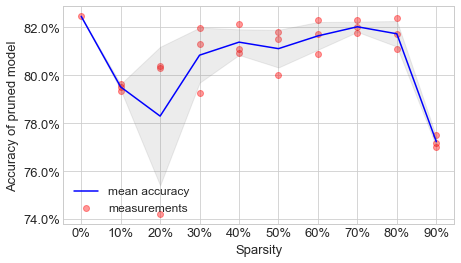

In [15]:
sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]
acc_points = []

acc_means = [get_results_for("pruning", n)["mean"]["acc"] for n in sparsities]
acc_sds = [get_results_for("pruning", n)["sd"]["acc"] for n in sparsities]

for n in sparsities:
    acc_points += [(n, size) for size in (get_samples("pruning", n)["acc"])]
    
sparsities = [0] + sparsities 
acc_means = [baseline_metrics["acc"]] + acc_means
acc_sds = [0] + acc_sds
acc_points.append((0, baseline_metrics["acc"]))

acc_means = np.array(acc_means)
acc_sds = np.array(acc_sds)

x, y = list(zip(*acc_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(sparsities, acc_means, c="blue", label="mean accuracy")
plt.fill_between(sparsities, acc_means - acc_sds, acc_means + acc_sds,
                 color='grey', alpha=0.15)
plt.xticks(sparsities, sparsities)
plt.xlabel("Sparsity", size=13)
plt.ylabel("Accuracy of pruned model", size=13)

plt.legend(loc="lower left", prop={'size': 12})

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)

xticks = mtick.PercentFormatter()
ax.xaxis.set_major_formatter(xticks)

plt.savefig("figures_rafdb/pruning_acc.svg")

### Gender Fairness

In [16]:
results = [["baseline", baseline_metrics["size"], baseline_metrics["acc"], baseline_metrics["f_acc"], baseline_metrics["m_acc"]]] 

sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for n in sparsities: 
    pr_res = [get_results_for("pruning", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc"]]
    pr_res = ["pruning @ " + str(n)] + pr_res
    pr_q_res = [get_results_for("pruning_and_quantisation", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc", ]]
    pr_q_res = ["pruning + quantisation @ " + str(n)] + pr_q_res
    
    results.append(pr_res)
    results.append(pr_q_res)

In [17]:
df = pd.DataFrame(results, columns=["Method", "Model size", "Overall accuracy", "Female accuracy", "Male accuracy"])
df

,Method,Model size,Overall accuracy,Female accuracy,Male accuracy
0,baseline,2.980182e+07,0.824641,0.833333,0.805444
1,pruning @ 10,2.815345e+07,0.795198,0.800412,0.786496
2,pruning + quantisation @ 10,6.444067e+06,0.795415,0.800617,0.786229
3,pruning @ 20,2.601093e+07,0.783029,0.787243,0.774753
4,pruning + quantisation @ 20,6.293085e+06,0.783246,0.786831,0.775821
5,pruning @ 30,2.365261e+07,0.808453,0.813786,0.796904
6,pruning + quantisation @ 30,6.035305e+06,0.808561,0.814403,0.795837
7,pruning @ 40,2.109197e+07,0.813885,0.819547,0.799306
8,pruning + quantisation @ 40,5.554811e+06,0.814646,0.820576,0.799840
9,pruning @ 50,1.841581e+07,0.811169,0.818930,0.795837


In [18]:
a = df[df['Method'].str.contains(r'pruning @')]["Model size"].values 
b = df[df['Method'].str.contains(r'quantisation')]["Model size"].values
print("Average reduction from quantisation:", (1 - np.mean(b / a)) * 100, "%")
print("Or a reduction of", np.mean(a/b), "times")

Average reduction from quantisation: 73.57465793089459 %
Or a reduction of 3.80327886695439 times


### Race Fairness

In [19]:
results = [[
    "baseline", 
    baseline_metrics["size"], 
    baseline_metrics["acc"], 
    baseline_metrics["caucasian_acc"], 
    baseline_metrics["afamerican_acc"], 
    baseline_metrics["asian_acc"]
]] 

sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for n in sparsities: 
    pr_res = [get_results_for("pruning", n)["mean"][key] for key in [
        "size", "acc", "caucasian_acc", "afamerican_acc", "asian_acc"
    ]]
    pr_res = ["pruning @ " + str(n)] + pr_res
    pr_q_res = [get_results_for("pruning_and_quantisation", n)["mean"][key] for key in [
        "size", "acc", "caucasian_acc", "afamerican_acc", "asian_acc" 
    ]]
    pr_q_res = ["pruning + quantisation @ " + str(n)] + pr_q_res
    
    results.append(pr_res)
    results.append(pr_q_res)

In [20]:
df = pd.DataFrame(results, columns=[
    "Method", "Model size", "Overall accuracy", "Caucasian accuracy", "African American accuracy", "Asian accuracy"
])
df

,Method,Model size,Overall accuracy,Caucasian accuracy,African American accuracy,Asian accuracy
0,baseline,2.980182e+07,0.824641,0.819226,0.867521,0.830228
1,pruning @ 10,2.815345e+07,0.795198,0.790018,0.819088,0.808834
2,pruning + quantisation @ 10,6.444067e+06,0.795415,0.790586,0.819088,0.807453
3,pruning @ 20,2.601093e+07,0.783029,0.781086,0.801994,0.783299
4,pruning + quantisation @ 20,6.293085e+06,0.783246,0.781653,0.801994,0.781919
5,pruning @ 30,2.365261e+07,0.808453,0.804480,0.843305,0.810904
6,pruning + quantisation @ 30,6.035305e+06,0.808561,0.805047,0.843305,0.808834
7,pruning @ 40,2.109197e+07,0.813885,0.809726,0.840456,0.821256
8,pruning + quantisation @ 40,5.554811e+06,0.814646,0.810577,0.840456,0.821946
9,pruning @ 50,1.841581e+07,0.811169,0.808592,0.843305,0.808144


### Age Fairness

In [21]:
results = [[
    "baseline", 
    baseline_metrics["size"], 
    baseline_metrics["acc"], 
    baseline_metrics["age0_acc"], 
    baseline_metrics["age1_acc"], 
    baseline_metrics["age2_acc"], 
    baseline_metrics["age3_acc"],
    baseline_metrics["age4_acc"]
]] 

sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for n in sparsities: 
    pr_res = [get_results_for("pruning", n)["mean"][key] for key in [
        "size", "acc", "age0_acc", "age1_acc", "age2_acc", "age3_acc", "age4_acc"
    ]]
    pr_res = ["pruning @ " + str(n)] + pr_res
    pr_q_res = [get_results_for("pruning_and_quantisation", n)["mean"][key] for key in [
        "size", "acc", "age0_acc", "age1_acc", "age2_acc", "age3_acc", "age4_acc"
    ]]
    pr_q_res = ["pruning + quantisation @ " + str(n)] + pr_q_res
    
    results.append(pr_res)
    results.append(pr_q_res)

In [22]:
df = pd.DataFrame(results, columns=[
    "Method", "Model size", "Overall accuracy", "Age0 acc", "Age1 acc", "Age2 acc", "Age3 acc", "Age4 acc"
])
df

,Method,Model size,Overall accuracy,Age0 acc,Age1 acc,Age2 acc,Age3 acc,Age4 acc
0,baseline,2.980182e+07,0.824641,0.899696,0.829218,0.804452,0.858566,0.707865
1,pruning @ 10,2.815345e+07,0.795198,0.825735,0.826475,0.785399,0.798805,0.674157
2,pruning + quantisation @ 10,6.444067e+06,0.795415,0.826748,0.825789,0.785800,0.799469,0.670412
3,pruning @ 20,2.601093e+07,0.783029,0.821682,0.793553,0.774769,0.793493,0.677903
4,pruning + quantisation @ 20,6.293085e+06,0.783246,0.820669,0.794925,0.774569,0.795485,0.674157
5,pruning @ 30,2.365261e+07,0.808453,0.855117,0.827160,0.789009,0.843293,0.700375
6,pruning + quantisation @ 30,6.035305e+06,0.808561,0.857143,0.827846,0.789210,0.841965,0.696629
7,pruning @ 40,2.109197e+07,0.813885,0.883485,0.827846,0.795628,0.837981,0.685393
8,pruning + quantisation @ 40,5.554811e+06,0.814646,0.883485,0.827846,0.796831,0.838645,0.685393
9,pruning @ 50,1.841581e+07,0.811169,0.870314,0.828532,0.791817,0.835989,0.719101


# 3. Clustering

### Model size

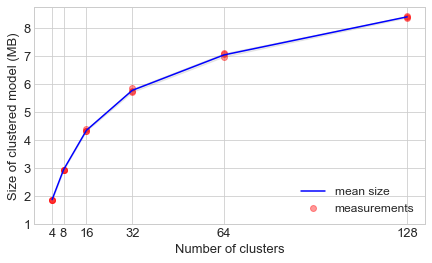

In [23]:
n_clusters = [4, 8, 16, 32, 64, 128]
size_points = []

size_means = np.array([get_results_for("clustering", n)["mean"]["size"] for n in n_clusters])
size_sds = np.array([get_results_for("clustering", n)["sd"]["size"] for n in n_clusters])

for n in n_clusters:
    size_points += [(n, size) for size in (get_samples("clustering", n)["size"])]

x, y = list(zip(*size_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(n_clusters, size_means, c="blue", label="mean size")
plt.fill_between(n_clusters, size_means - size_sds, size_means + size_sds,
                 color='grey', alpha=0.15)
plt.xticks(n_clusters, n_clusters)
plt.xlabel("Number of clusters", size=13)
plt.ylabel("Size of clustered model (MB)", size=13)

plt.legend(loc="lower right", prop={'size': 12})

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x // 1000000)
    return s

yfmt = mtick.FuncFormatter(numfmt)    # create your custom formatter function
ax.yaxis.set_major_formatter(yfmt)
ax.set_yticks(np.arange(1000000, 9000000, step=1000000))

plt.savefig("figures_rafdb/clustering_size.svg")

### Model accuracy

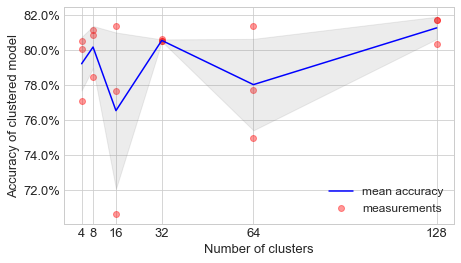

In [24]:
n_clusters = [4, 8, 16, 32, 64, 128]
acc_points = []

acc_means = np.array([get_results_for("clustering", n)["mean"]["acc"] for n in n_clusters])
acc_sds = np.array([get_results_for("clustering", n)["sd"]["acc"] for n in n_clusters])

for n in n_clusters:
    acc_points += [(n, acc) for acc in (get_samples("clustering", n)["acc"])]

x, y = list(zip(*acc_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(n_clusters, acc_means, c="blue", label="mean accuracy")
plt.fill_between(n_clusters, acc_means - acc_sds, acc_means + acc_sds,
                 color='grey', alpha=0.15)
plt.xticks(n_clusters, n_clusters)
plt.xlabel("Number of clusters", size=13)
plt.ylabel("Accuracy of clustered model", size=13)

plt.legend(loc="lower right", prop={'size': 12})

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)
plt.savefig("figures_rafdb/clustering_acc.svg")

### Gender Fairness

In [25]:
results = [["baseline", baseline_metrics["size"], baseline_metrics["acc"], baseline_metrics["f_acc"], baseline_metrics["m_acc"]]] 
n_clusters = [4, 8, 16, 32, 64, 128]

for n in n_clusters: 
    cl_res = [get_results_for("clustering", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc"]]
    cl_res = ["clustering @ " + str(n)] + cl_res
    cl_q_res = [get_results_for("clustering_and_quantisation", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc"]]
    cl_q_res = ["clustering + quantisation @ " + str(n)] + cl_q_res
    
    results.append(cl_res)
    results.append(cl_q_res)

In [26]:
df = pd.DataFrame(results, columns=["Method", "Model size", "Overall accuracy", "Female accuracy", "Male accuracy"])
df

,Method,Model size,Overall accuracy,Female accuracy,Male accuracy
0,baseline,2.980182e+07,0.824641,0.833333,0.805444
1,clustering @ 4,1.880628e+06,0.792264,0.797119,0.780891
2,clustering + quantisation @ 4,1.396900e+06,0.778900,0.787654,0.763277
3,clustering @ 8,2.945427e+06,0.801825,0.803909,0.793435
4,clustering + quantisation @ 8,2.291554e+06,0.799761,0.800206,0.793702
5,clustering @ 16,4.352143e+06,0.765428,0.774486,0.750200
6,clustering + quantisation @ 16,3.534598e+06,0.764450,0.772222,0.749933
7,clustering @ 32,5.774540e+06,0.805628,0.809465,0.794235
8,clustering + quantisation @ 32,4.715364e+06,0.806280,0.811317,0.794769
9,clustering @ 64,7.036701e+06,0.780313,0.780041,0.775554


### Race Fairness

In [27]:
results = [[
    "baseline", 
    baseline_metrics["size"], 
    baseline_metrics["acc"], 
    baseline_metrics["caucasian_acc"], 
    baseline_metrics["afamerican_acc"], 
    baseline_metrics["asian_acc"]
]] 

n_clusters = [4, 8, 16, 32, 64, 128]

for n in n_clusters: 
    cl_res = [get_results_for("clustering", n)["mean"][key] for key in [
        "size", "acc", "caucasian_acc", "afamerican_acc", "asian_acc"
    ]]
    cl_res = ["clustering @ " + str(n)] + cl_res
    cl_q_res = [get_results_for("clustering_and_quantisation", n)["mean"][key] for key in [
        "size", "acc", "caucasian_acc", "afamerican_acc", "asian_acc" 
    ]]
    cl_q_res = ["clustering + quantisation @ " + str(n)] + cl_q_res
    
    results.append(cl_res)
    results.append(cl_q_res)

In [28]:
df = pd.DataFrame(results, columns=[
    "Method", "Model size", "Overall accuracy", "Caucasian accuracy", "African American accuracy", "Asian accuracy"
])
df

,Method,Model size,Overall accuracy,Caucasian accuracy,African American accuracy,Asian accuracy
0,baseline,2.980182e+07,0.824641,0.819226,0.867521,0.830228
1,clustering @ 4,1.880628e+06,0.792264,0.790586,0.790598,0.801242
2,clustering + quantisation @ 4,1.396900e+06,0.778900,0.776265,0.784900,0.788820
3,clustering @ 8,2.945427e+06,0.801825,0.797533,0.814815,0.816425
4,clustering + quantisation @ 8,2.291554e+06,0.799761,0.794697,0.823362,0.812974
5,clustering @ 16,4.352143e+06,0.765428,0.759251,0.787749,0.784679
6,clustering + quantisation @ 16,3.534598e+06,0.764450,0.758684,0.783476,0.783299
7,clustering @ 32,5.774540e+06,0.805628,0.801361,0.826211,0.816425
8,clustering + quantisation @ 32,4.715364e+06,0.806280,0.801503,0.830484,0.817805
9,clustering @ 64,7.036701e+06,0.780313,0.773855,0.814815,0.795031


### Age Fairness

In [29]:
results = [[
    "baseline", 
    baseline_metrics["size"], 
    baseline_metrics["acc"], 
    baseline_metrics["age0_acc"], 
    baseline_metrics["age1_acc"], 
    baseline_metrics["age2_acc"], 
    baseline_metrics["age3_acc"],
    baseline_metrics["age4_acc"]
]] 

n_clusters = [4, 8, 16, 32, 64, 128]

for n in n_clusters: 
    cl_res = [get_results_for("clustering", n)["mean"][key] for key in [
        "size", "acc", "age0_acc", "age1_acc", "age2_acc", "age3_acc", "age4_acc"
    ]]
    cl_res = ["clustering @ " + str(n)] + cl_res
    cl_q_res = [get_results_for("clustering_and_quantisation", n)["mean"][key] for key in [
        "size", "acc", "age0_acc", "age1_acc", "age2_acc", "age3_acc", "age4_acc"
    ]]
    cl_q_res = ["clustering + quantisation @ " + str(n)] + cl_q_res
    
    results.append(cl_res)
    results.append(cl_q_res)

In [30]:
df = pd.DataFrame(results, columns=[
    "Method", "Model size", "Overall accuracy", "Age0 acc", "Age1 acc", "Age2 acc", "Age3 acc", "Age4 acc"
])
df

,Method,Model size,Overall accuracy,Age0 acc,Age1 acc,Age2 acc,Age3 acc,Age4 acc
0,baseline,2.980182e+07,0.824641,0.899696,0.829218,0.804452,0.858566,0.707865
1,clustering @ 4,1.880628e+06,0.792264,0.856130,0.815501,0.769354,0.818061,0.711610
2,clustering + quantisation @ 4,1.396900e+06,0.778900,0.825735,0.795610,0.761131,0.810757,0.666667
3,clustering @ 8,2.945427e+06,0.801825,0.851064,0.816187,0.786803,0.822709,0.704120
4,clustering + quantisation @ 8,2.291554e+06,0.799761,0.848024,0.814129,0.784998,0.823373,0.685393
5,clustering @ 16,4.352143e+06,0.765428,0.806484,0.792181,0.751504,0.785525,0.614232
6,clustering + quantisation @ 16,3.534598e+06,0.764450,0.805471,0.793553,0.752306,0.774900,0.621723
7,clustering @ 32,5.774540e+06,0.805628,0.863222,0.823045,0.789009,0.826029,0.692884
8,clustering + quantisation @ 32,4.715364e+06,0.806280,0.857143,0.825789,0.793020,0.818061,0.692884
9,clustering @ 64,7.036701e+06,0.780313,0.829787,0.799040,0.760730,0.809429,0.696629


# Dataset balance

In [31]:
import os

In [32]:
train_dist = {em: 0 for em in range(1, 8)}
for emotion in range(1, 8): 
    files = os.listdir("/Users/samuilstoychev/RAF_DB_preprocessed/train/class_" + str(emotion))
    for file in files: 
        train_dist[emotion] += 1

In [33]:
test_dist = {em: 0 for em in range(1, 8)}
for emotion in range(1, 8): 
    files = os.listdir("/Users/samuilstoychev/RAF_DB_preprocessed/test/class_" + str(emotion))
    for file in files: 
        test_dist[emotion] += 1

### Train dataset distribution of emotions

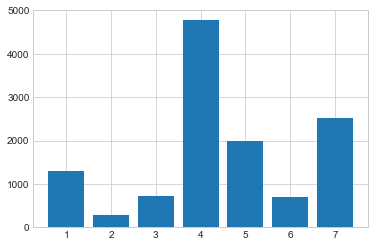

In [34]:
plt.bar(range(len(train_dist)), list(train_dist.values()), align='center')
plt.xticks(range(len(train_dist)), list(train_dist.keys()))
plt.show()

### Test dataset distribution of emotions

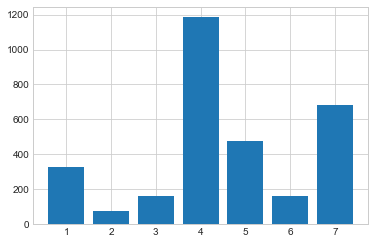

In [35]:
plt.bar(range(len(test_dist)), list(test_dist.values()), align='center')
plt.xticks(range(len(test_dist)), list(test_dist.keys()))
plt.show()